In [113]:
# Chapter 7. Time Series Analysis and Financial Data Forecasting

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#!pip install --upgrade yfinance
import yfinance as yf

In [115]:
# Time Series libraries
import statsmodels.api as sm
# !pip install pmdarima # uncomment is it need
import pmdarima as pm

In [116]:
# Frequently used functions
from pandas.tseries.offsets import BDay

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Import DataSets from Chapter 6 Results

### Get Data from Internet

In [117]:
if True: # Make True to Get data from Internet
  # Top Assets of NASDAQ stock exchange
  nasdaq_tickers = [
      'MRNA',  # Moderna, Inc.
      'DLTR',  # Dollar Tree, Inc.
    # 'CEG',   # Constellation Energy Corporation (started from 2022-01-19)
      'ZS',    # Zscaler, Inc.
      'MCHP',  # Microchip Technology Incorporated
      'SBUX',  # Starbucks Corporation
      'HON',   # Honeywell International Inc.
      'JD',    # JD.com, Inc.
      'DDOG',  # Datadog, Inc.
      'AMAT',  # Applied Materials, Inc.
      'AAPL',  # Apple Inc.
      'AMGN',  # Amgen Inc.
      'INTU',  # Intuit Inc.
      'PCAR',  # PACCAR Inc
      'MDLZ',  # Mondelez International, Inc.
      'CSGP',  # CoStar Group, Inc.
      'FTNT',  # Fortinet, Inc.
      'KDP',   # Keurig Dr Pepper Inc.
      'META',  # Meta Platforms, Inc.
      'VRSK',  # Verisk Analytics, Inc.
      'MAR',   # Marriott International, Inc.
      'MRVL',  # Marvell Technology, Inc.
      'AZN',   # AstraZeneca PLC
      'ILMN',  # Illumina, Inc.
      'ENPH',  # Enphase Energy, Inc.
      'SIRI',  # Sirius XM Holdings Inc.
      'MELI',  # MercadoLibre, Inc.
      'ZM',    # Zoom Video Communications, Inc.
      'TSLA',  # Tesla, Inc.
      'BKR',   # Baker Hughes Company
      'URBN'   # Urban Outfitters, Inc.
  ]

  start='2021-01-01'
  end='2023-10-01'

  # Download stock data
  df = yf.download(tickers=nasdaq_tickers,
                  start=start, end=end,
                  actions=False)
  # Make a subset by the 'Adj Close' and 'Volume' columns
  df = df.loc[:, ['Adj Close', 'Volume']]
  df = df.sort_index()
  # Creating a Multi-Level Column Structure for 'RoR'
  pct_change = df['Adj Close'].pct_change()
  pct_change.columns = pd.MultiIndex.from_product([['RoR'],
                                                  pct_change.columns])
  # Concatenating the new 'RoR' DataFrame with the original DataFrame
  df = pd.concat([df, pct_change], axis=1)
  df.dropna(inplace=True)
  # Displaying the updated DataFrame
  print(df.head())
  # Save data files
  df.to_csv('nasdaq_assets.csv')

  # Ticker symbol for NASDAQ-100 index
  index_ticker = '^NDX'  # This is a common symbol used for the NASDAQ-100 index

  # Downloading historical data for the index
  index_data = yf.download(index_ticker,
                          start=start,
                          end=end)
  index_data['RoR'] = index_data['Adj Close'].pct_change()
  index_data.dropna(inplace=True)
  print(index_data.head())
  index_data.to_csv('nasdaq_index.csv')

[*********************100%%**********************]  30 of 30 completed
[*********************100%%**********************]  1 of 1 completed


             Adj Close                                               \
Ticker            AAPL       AMAT        AMGN        AZN        BKR   
Date                                                                  
2021-01-05  128.398178  87.034210  203.932800  46.486187  19.333618   
2021-01-06  124.076088  88.228989  208.848450  46.678734  20.152069   
2021-01-07  128.309952  91.852173  209.537918  46.018570  20.615860   
2021-01-08  129.417465  92.823540  213.540283  46.632893  20.433981   
2021-01-11  126.408630  95.154808  212.716522  46.357822  20.597672   

                                                                      ...  \
Ticker           CSGP        DDOG        DLTR        ENPH       FTNT  ...   
Date                                                                  ...   
2021-01-05  89.379997   93.029999  107.129997  181.479996  28.348000  ...   
2021-01-06  89.669998   91.330002  112.970001  203.380005  27.622000  ...   
2021-01-07  90.547997   96.639999  114.750000 

### Load data from the local files

In [118]:
nasdaq_assets = pd.read_csv('nasdaq_assets.csv',
                               index_col = 0,
                               parse_dates=[0],
                               header = [0, 1])
nasdaq_assets_ac = nasdaq_assets['Adj Close']
print(nasdaq_assets_ac.head())

Ticker            AAPL       AMAT        AMGN        AZN        BKR  \
Date                                                                  
2021-01-05  128.398178  87.034210  203.932800  46.486187  19.333618   
2021-01-06  124.076088  88.228989  208.848450  46.678734  20.152069   
2021-01-07  128.309952  91.852173  209.537918  46.018570  20.615860   
2021-01-08  129.417465  92.823540  213.540283  46.632893  20.433981   
2021-01-11  126.408630  95.154808  212.716522  46.357822  20.597672   

Ticker           CSGP        DDOG        DLTR        ENPH       FTNT  ...  \
Date                                                                  ...   
2021-01-05  89.379997   93.029999  107.129997  181.479996  28.348000  ...   
2021-01-06  89.669998   91.330002  112.970001  203.380005  27.622000  ...   
2021-01-07  90.547997   96.639999  114.750000  213.759995  28.650000  ...   
2021-01-08  91.952003   99.940002  112.970001  207.410004  29.628000  ...   
2021-01-11  90.436996  104.250000  112.4

In [119]:
nasdaq_index = pd.read_csv('nasdaq_index.csv',
                           index_col=0,
                           parse_dates=['Date'])
nasdaq_index_ac = nasdaq_index['Adj Close']
nasdaq_index_pc = nasdaq_index['RoR']
print(nasdaq_index_ac.head())

Date
2021-01-05    12802.379883
2021-01-06    12623.349609
2021-01-07    12939.570312
2021-01-08    13105.200195
2021-01-11    12902.490234
Name: Adj Close, dtype: float64


## Introduction to Time Series Data Forecasting

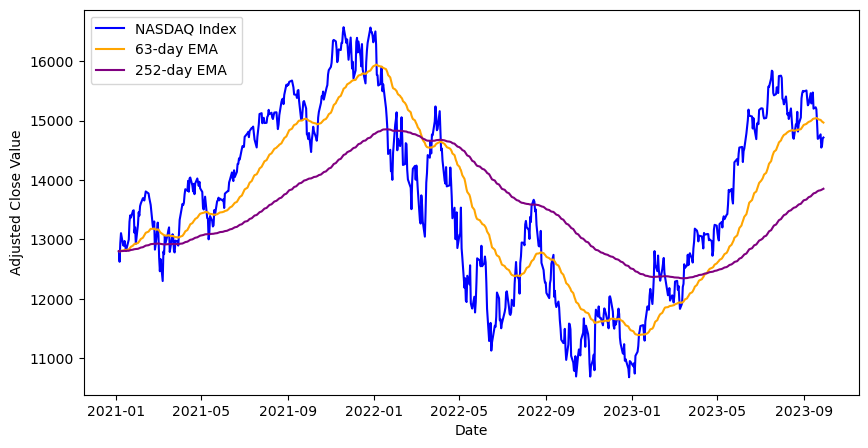

In [120]:
# Calculate the Exponential Moving Average for different periods
nasdaq_index_ac_df = pd.DataFrame({
    'Index': nasdaq_index_ac,
    'EMA_63': nasdaq_index_ac.ewm(span=63, adjust=False).mean(),
    'EMA_252': nasdaq_index_ac.ewm(span=252, adjust=False).mean()
})
# Plotting - NASDAQ Index with EMA trends
plt.figure(figsize=(10, 5))
plt.plot(nasdaq_index_ac_df['Index'], 
         label='NASDAQ Index', color='blue')
plt.plot(nasdaq_index_ac_df['EMA_63'], 
         label='63-day EMA', color='orange')
plt.plot(nasdaq_index_ac_df['EMA_252'],
         label='252-day EMA', color='purple')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Value')
plt.legend()
plt.show()

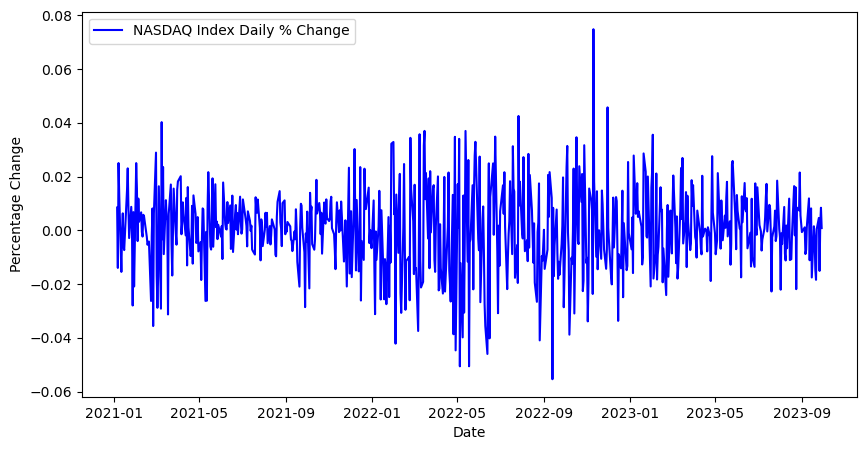

In [121]:
# Plotting - NASDAQ Index Percentage Change (Stationarity illustration)
plt.figure(figsize=(10, 5))
plt.plot(nasdaq_index_pc, label='NASDAQ Index Daily % Change', color='blue')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.legend()
plt.show()

In [122]:
# Autocorrelation matrix
nasdaq_index_ac_autocorr = pd.DataFrame({
    'Shift_0': nasdaq_index_ac,
    'Shift_1': nasdaq_index_ac.shift(1),
    'Shift_2': nasdaq_index_ac.shift(2),
    'Shift_3': nasdaq_index_ac.shift(3),
    'Shift_4': nasdaq_index_ac.shift(4),
    'Shift_5': nasdaq_index_ac.shift(5)
})
print(nasdaq_index_ac_autocorr.head(), '\n')
print(nasdaq_index_ac_autocorr.dropna().corr())

                 Shift_0       Shift_1       Shift_2       Shift_3  \
Date                                                                 
2021-01-05  12802.379883           NaN           NaN           NaN   
2021-01-06  12623.349609  12802.379883           NaN           NaN   
2021-01-07  12939.570312  12623.349609  12802.379883           NaN   
2021-01-08  13105.200195  12939.570312  12623.349609  12802.379883   
2021-01-11  12902.490234  13105.200195  12939.570312  12623.349609   

                 Shift_4  Shift_5  
Date                               
2021-01-05           NaN      NaN  
2021-01-06           NaN      NaN  
2021-01-07           NaN      NaN  
2021-01-08           NaN      NaN  
2021-01-11  12802.379883      NaN   

          Shift_0   Shift_1   Shift_2   Shift_3   Shift_4   Shift_5
Shift_0  1.000000  0.990797  0.982101  0.974073  0.966867  0.959630
Shift_1  0.990797  1.000000  0.990780  0.982100  0.974055  0.966854
Shift_2  0.982101  0.990780  1.000000  0.990772  0.

### Pandas time series data manipulation

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

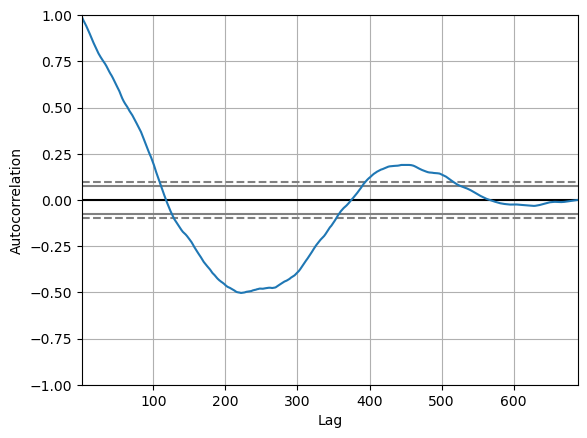

In [123]:
# Plotting autocorrelation matrix
pd.plotting.autocorrelation_plot(nasdaq_index_ac)

In [124]:
# Define a CustomBusinessDay object with specified holidays
custom_bday = pd.offsets.CustomBusinessDay(holidays=['2023-01-01', '2023-01-03'])

# Generate a date range for ordinary business days, excluding the holiday
date_range = pd.date_range(start='2022-12-31', end='2023-01-05', freq=custom_bday)

# Display the date range
print(date_range)

# Create a calendar object
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()

# Define a date range you are interested in
start_date = '2023-01-01'
end_date = '2023-12-31'

# Get the holidays within the date range
holidays = cal.holidays(start=start_date, end=end_date)
print(holidays)

# Convert to a list
holidays_list = list(holidays)
print(holidays_list)

DatetimeIndex(['2023-01-02', '2023-01-04', '2023-01-05'], dtype='datetime64[ns]', freq='C')
DatetimeIndex(['2023-01-02', '2023-01-16', '2023-02-20', '2023-05-29',
               '2023-06-19', '2023-07-04', '2023-09-04', '2023-10-09',
               '2023-11-10', '2023-11-23', '2023-12-25'],
              dtype='datetime64[ns]', freq=None)
[Timestamp('2023-01-02 00:00:00'), Timestamp('2023-01-16 00:00:00'), Timestamp('2023-02-20 00:00:00'), Timestamp('2023-05-29 00:00:00'), Timestamp('2023-06-19 00:00:00'), Timestamp('2023-07-04 00:00:00'), Timestamp('2023-09-04 00:00:00'), Timestamp('2023-10-09 00:00:00'), Timestamp('2023-11-10 00:00:00'), Timestamp('2023-11-23 00:00:00'), Timestamp('2023-12-25 00:00:00')]


In [125]:
# Resampling data and calculate average for monthly periods
print("Monthly Average Prices:")
print(nasdaq_index_ac.resample('M').mean().head())

# Change index to PeriodIndex for better representation of periods
print("\nMonthly Average Prices with PeriodIndex:")
print(nasdaq_index_ac.resample('M').mean().to_period('M').head())

Monthly Average Prices:
Date
2021-01-31    13067.708442
2021-02-28    13473.779965
2021-03-31    12900.192255
2021-04-30    13832.342913
2021-05-31    13470.814014
Freq: ME, Name: Adj Close, dtype: float64

Monthly Average Prices with PeriodIndex:
Date
2021-01    13067.708442
2021-02    13473.779965
2021-03    12900.192255
2021-04    13832.342913
2021-05    13470.814014
Freq: M, Name: Adj Close, dtype: float64


/var/folders/02/hsxm96k91cl40xffg5xlqvhm0000gn/T/ipykernel_47284/2858551004.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  print(nasdaq_index_ac.resample('M').mean().head())
/var/folders/02/hsxm96k91cl40xffg5xlqvhm0000gn/T/ipykernel_47284/2858551004.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  print(nasdaq_index_ac.resample('M').mean().to_period('M').head())


In [126]:
# Example showing the month number for each date in the index
print("Month numbers for each date in the index:\n")
print(nasdaq_index_ac.index.month)

# Example showing the quarter number for each date in the index
print("\nQuarter numbers for each date in the index:\n")
print(nasdaq_index_ac.index.quarter)

# Example showing the day of the week for each date in the index (Monday=0, Sunday=6)
print("\nDay of the week for each date in the index:\n")
print(nasdaq_index_ac.index.dayofweek)

Month numbers for each date in the index:

Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       ...
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
      dtype='int32', name='Date', length=689)

Quarter numbers for each date in the index:

Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       ...
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
      dtype='int32', name='Date', length=689)

Day of the week for each date in the index:

Index([1, 2, 3, 4, 0, 1, 2, 3, 4, 1,
       ...
       0, 1, 2, 3, 4, 0, 1, 2, 3, 4],
      dtype='int32', name='Date', length=689)


## Statistical Metrics

In [127]:
# Import metrics calculation tools
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [128]:
# Custom functions for metrics calculation tools
# Mean Squared Error (MSE)
def calculate_mse(actual, forecast):
    squared_errors = (actual - forecast) ** 2
    return squared_errors.mean()
# Mean Absolute Error (MAE)
def calculate_mae(actual, forecast):
    differences = abs(actual - forecast)
    return differences.mean()
# Mean Absolute Percentage Error (MAPE)
def calculate_mape(actual, forecast):
    mape = abs((actual - forecast) / actual) * 100
    return mape.mean()

In [129]:
# Load dataset from seaborn library
flights_df = sns.load_dataset('flights')

In [130]:
# Extracting the 'passengers' column from the flights dataset
df = flights_df['passengers']
print("The statistical metrics for 12-month EMA")
# Calculate Root Mean Squared Error (RMSE) between the actual data and its 12-month EMA
rmse = np.sqrt(calculate_mse(df, df.ewm(span=12).mean()))
print("Root Mean Squared Error (RMSE):", rmse)
# Calculate Mean Absolute Error (MAE) between the actual data and its 12-month EMA
mae = calculate_mae(df, df.ewm(span=12).mean())
print("Mean Absolute Error (MAE):", mae)
# Calculate Mean Absolute Percentage Error (MAPE) between the actual data and its 12-month EMA
mape = calculate_mape(df, df.ewm(span=12).mean())
print("Mean Absolute Percentage Error (MAPE):", mape)
# Calculate the metrics for the 3-month EMA
print("\nThe statistical metrics for 3-month EMA")
rmse = np.sqrt(calculate_mse(df, df.ewm(span=3).mean()))
print("Root Mean Squared Error (RMSE):", rmse)
mae = calculate_mae(df, df.ewm(span=3).mean())
print("Mean Absolute Error (MAE):", mae)
mape = calculate_mape(df, df.ewm(span=3).mean())
print("Mean Absolute Percentage Error (MAPE):", mape)

The statistical metrics for 12-month EMA
Root Mean Squared Error (RMSE): 41.312675718459396
Mean Absolute Error (MAE): 29.475854274073374
Mean Absolute Percentage Error (MAPE): 9.725760321816697

The statistical metrics for 3-month EMA
Root Mean Squared Error (RMSE): 20.78898699971608
Mean Absolute Error (MAE): 15.3986847855742
Mean Absolute Percentage Error (MAPE): 5.21703698803825


In [131]:
# Extracting the 'passengers' column from the flights dataset
df = flights_df['passengers']
print("MAPE for actual and 12-month EMA data")
# Calculate Mean Absolute Percentage Error (MAPE) between the actual data and its 12-month EMA
mape = mean_absolute_percentage_error(df, df.ewm(span=12).mean())*100
print("Mean Absolute Percentage Error (MAPE):", mape)
# Calculate the metrics for the 3-month EMA
print("\nMAPE for actual and 3-month EMA data")
mape = mean_absolute_percentage_error(df, df.ewm(span=3).mean())*100
print("Mean Absolute Percentage Error (MAPE):", mape)

MAPE for actual and 12-month EMA data
Mean Absolute Percentage Error (MAPE): 9.725760321816695

MAPE for actual and 3-month EMA data
Mean Absolute Percentage Error (MAPE): 5.217036988038251


## Holt-Winters Model

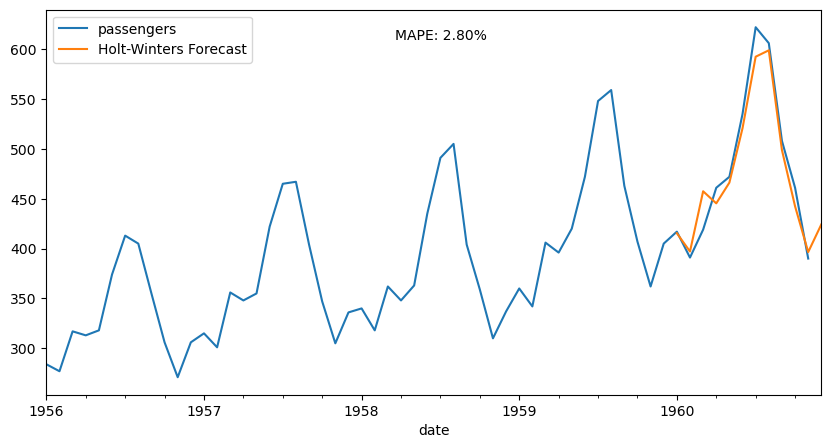

In [155]:
# Load ExponentialSmoothing initial method
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Load dataset from seaborn library
flights_df = sns.load_dataset('flights')
# Convert 'month' to its numeric representation
flights_df['month'] = pd.to_datetime(flights_df['month'], 
                                     format='%b').dt.month
# Create a combined 'year-month' column and convert it to datetime
flights_df['date'] = pd.to_datetime(flights_df['year'].astype(str) + \
                                    
                                    '-' + flights_df['month'].astype(str))
# Set 'date' as an index and convert it to PeriodIndex
flights_df.set_index('date', inplace=True)
flights_df.index = flights_df.index.to_period('M')
# Training and test set
test_period = 12
df = flights_df['passengers']
train_set = df.iloc[:-test_period]
test_set = df.iloc[-test_period:]
# Forecasting model
model = ExponentialSmoothing(endog = train_set,
                             trend = 'add',     # 'mul' or 'add'
                             seasonal = 'add',  # 'mul' or 'add'
                             seasonal_periods = 12).fit()
# Predictions
predictions_hw = model.forecast(steps = test_period).rename("Holt-Winters Forecast")
predictions_hw.index = test_set.index
predictions_hw.head()
# Visualization
df[-60:-1].plot(figsize = (10,5), legend = True)
predictions_hw.plot(legend = True)
# Displaying the MAPE value on the plot
m_mape = mean_absolute_percentage_error(test_set, predictions_hw) * 100
plt.text(0.45, 0.95, f'MAPE: {m_mape:.2f}%', 
         transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top')
plt.show()

<Figure size 640x480 with 0 Axes>

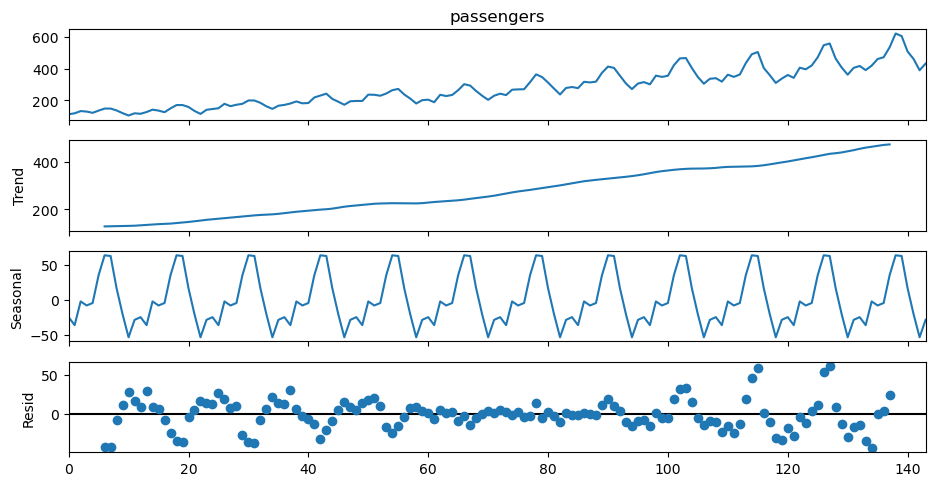

<Figure size 640x480 with 0 Axes>

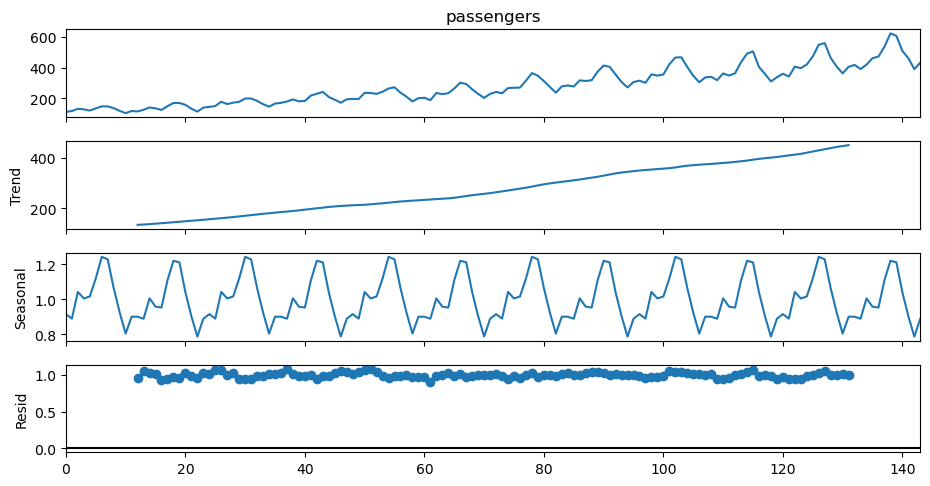

In [133]:
# Seasonality decompose
# The seasonal_decompose() do not work with PeriodIndex
flights = sns.load_dataset('flights') 
# Use an additive model to decompose
# Yt = Tt (Trend) + St (Seasonal) + Et (Residual (error))
decomp = seasonal_decompose(flights['passengers'],
                            period = 12,
                            model = 'add')
fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(10, 5)
# Use a multiplicative model to decompose
# Yt = Tt (Trend) × St (Seasonal) × Et (Residual (error))
decomp = seasonal_decompose(flights['passengers'],
                            period = 24,
                            model = 'mul')
fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(10, 5)
plt.show()

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


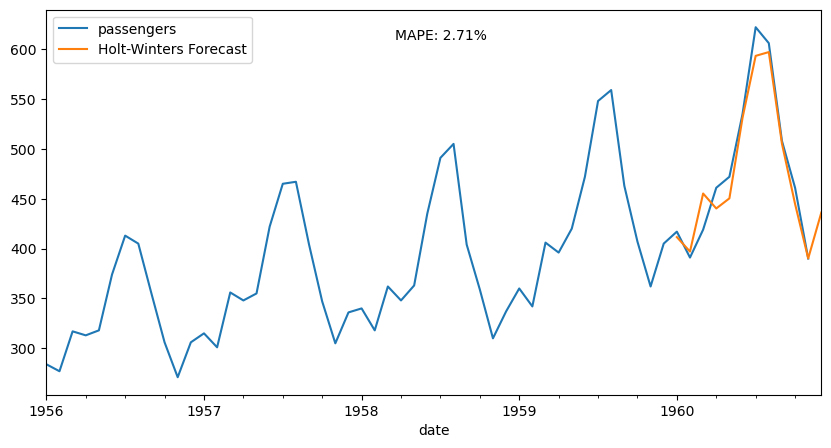

In [134]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# Training and test set
test_period = 12
df = flights_df['passengers']
train_set = df.iloc[:-test_period]
test_set = df.iloc[-test_period:]
# Forecasting model
model = ExponentialSmoothing(endog = train_set,
                             trend = 'mul',     # 'mul' or 'add'
                             seasonal = 'mul',  # 'mul' or 'add'
                             seasonal_periods = 24).fit()
# Predictions
predictions_hw = model.forecast(steps = test_period).rename("Holt-Winters Forecast")
predictions_hw.index = test_set.index
predictions_hw.head()
# Visualization
df[-60:-1].plot(figsize = (10,5), legend = True)
predictions_hw.plot(legend = True)
# Displaying the MAPE value on the plot
m_mape = mean_absolute_percentage_error(test_set, predictions_hw) * 100
plt.text(0.45, 0.95, f'MAPE: {m_mape:.2f}%',
         transform=plt.gca().transAxes, fontsize=10, 
         verticalalignment='top')
plt.show()

### Simulated Data Set (additional material)

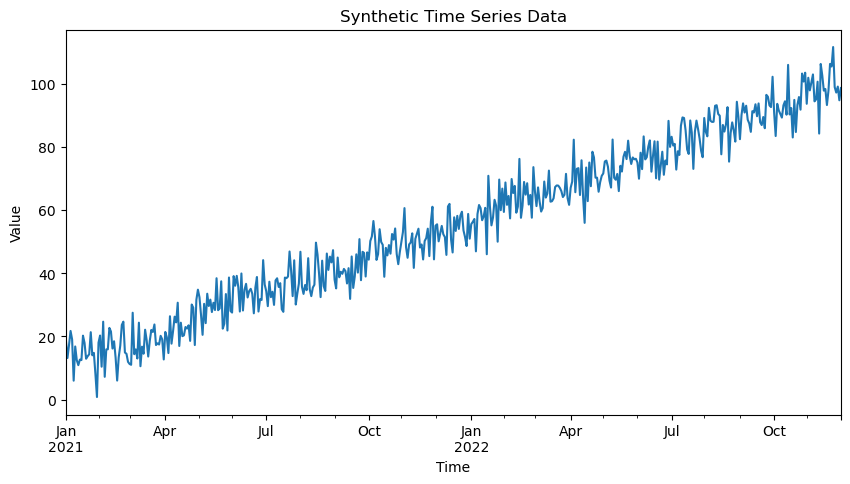

In [135]:
# Settings for the simulated dataset
# - Create a linearly increasing trend.
# - Add a repeating seasonal pattern that simulates weekly seasonality.
# - Include random noise using a normal distribution to add variability.
np.random.seed(0)  # for reproducibility
n_periods = 250 * 2 # number of periods (two years in business days)
seasonal_period = 5  # daily data with weekly seasonality

# Generate a linear trend
trend = np.linspace(10, 100, n_periods)

# Generate seasonal component -
seasonal = np.tile(np.array([0, 1, 2, 0, -1]), 
                   int(n_periods / seasonal_period))

# Combine trend and seasonality and add some noise
data = trend + seasonal + np.random.normal(scale=5, size=n_periods)

# Create a pandas Series with a time index
time_index = pd.date_range(start='2021-01-01', 
                           periods=n_periods, freq=BDay())
sim_ts = pd.Series(data, name = 'Simulated Time Series Data', 
                   index=time_index)

# Plot the data
sim_ts.plot(figsize=(10, 5))
plt.title('Synthetic Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

<Figure size 640x480 with 0 Axes>

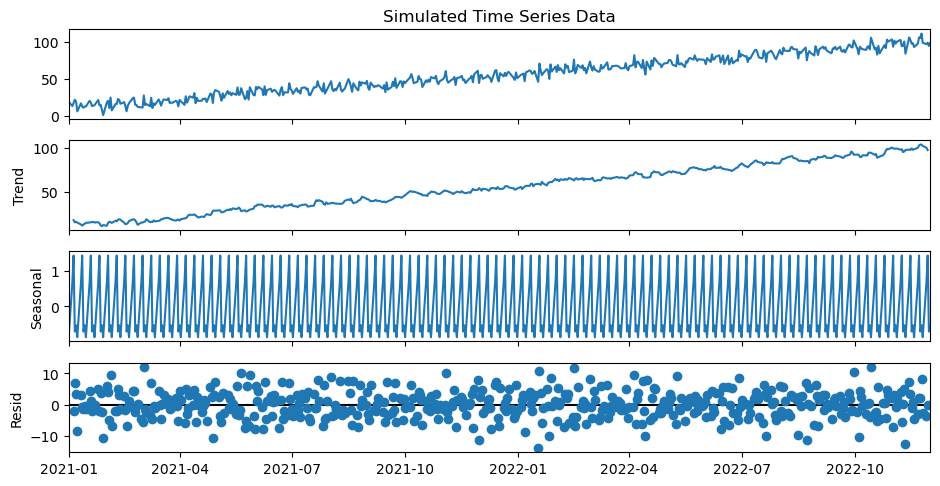

In [136]:
# Seasonality decompose
decomp = seasonal_decompose(sim_ts.asfreq('B'),
                            period = 5,
                            model ='add')
fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(10, 5)

<Figure size 640x480 with 0 Axes>

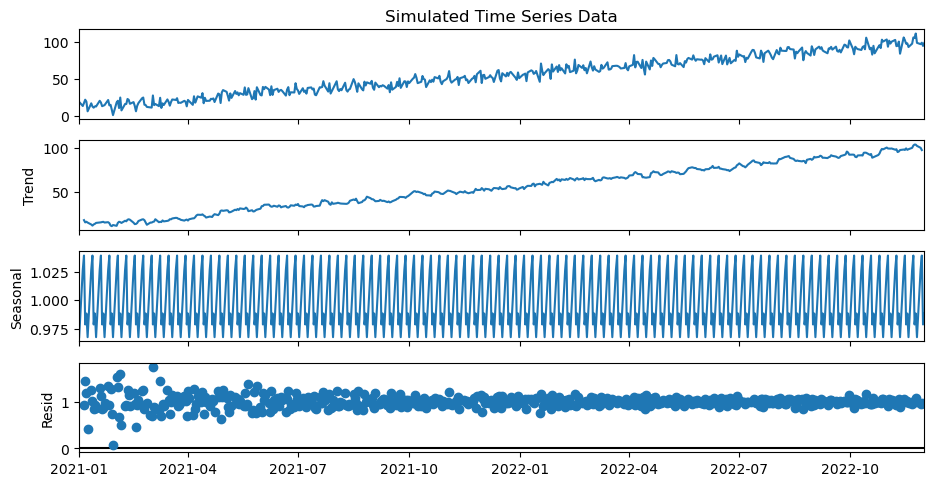

In [137]:
# Seasonality decompose
decomp = seasonal_decompose(sim_ts.asfreq('B'),
                            period = 5,
                            model ='mul')
fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(10, 5)
plt.show()

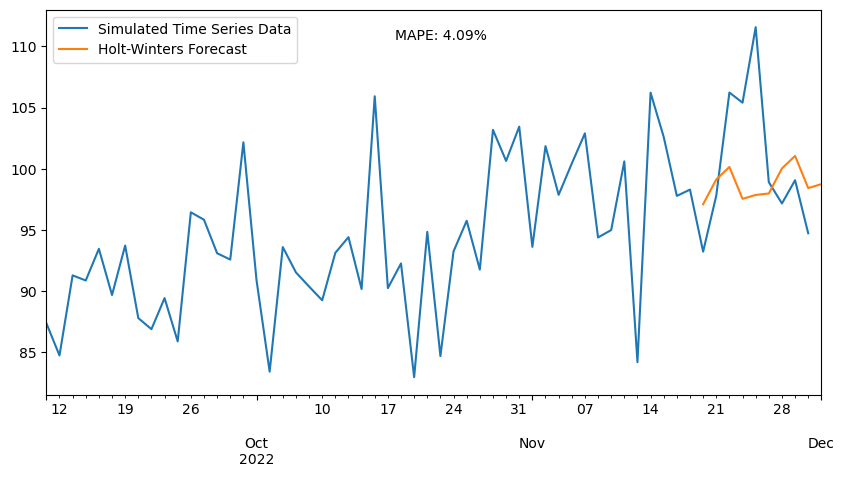

In [138]:
#Training and test set
test_days = 10
df = sim_ts
train_set = df.iloc[:-test_days]
test_set = df.iloc[-test_days:]

# Forecasting model
model = ExponentialSmoothing(endog = train_set,
                             trend = 'add',     # 'mul' or 'add'
                             seasonal = 'mul',  # 'mul' or 'add'
                             seasonal_periods = 5).fit()

# Predictions for work days
predictions_hw = model.forecast(steps = test_days).rename("Holt-Winters Forecast")
predictions_hw.index = test_set.index
predictions_hw.head()
# Visualization
df[-60:-1].plot(figsize = (10,5), legend = True)
predictions_hw.plot(legend = True)
# Displaying the MAPE value on the plot
m_mape = mean_absolute_percentage_error(test_set, predictions_hw) * 100
plt.text(0.45, 0.95, f'MAPE: {m_mape:.2f}%', 
         transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top')
plt.show()

### HW Model on Real World Data Set (additional material)

<Figure size 640x480 with 0 Axes>

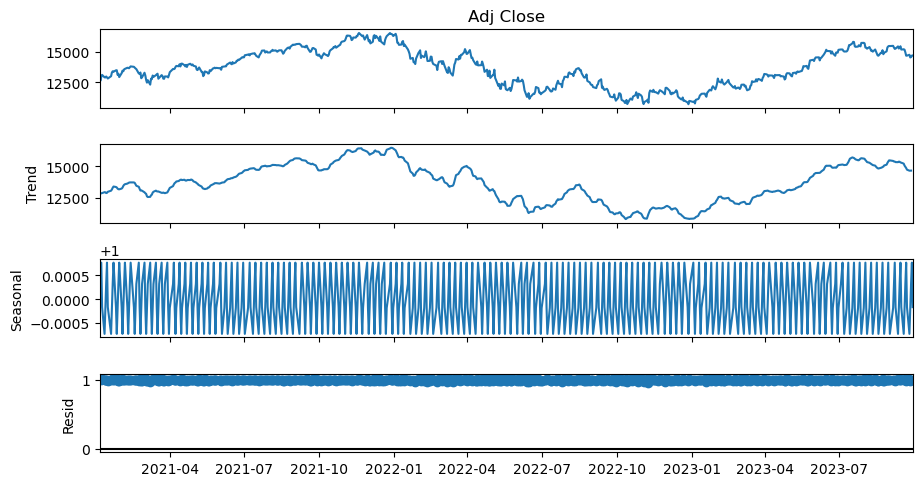

<Figure size 640x480 with 0 Axes>

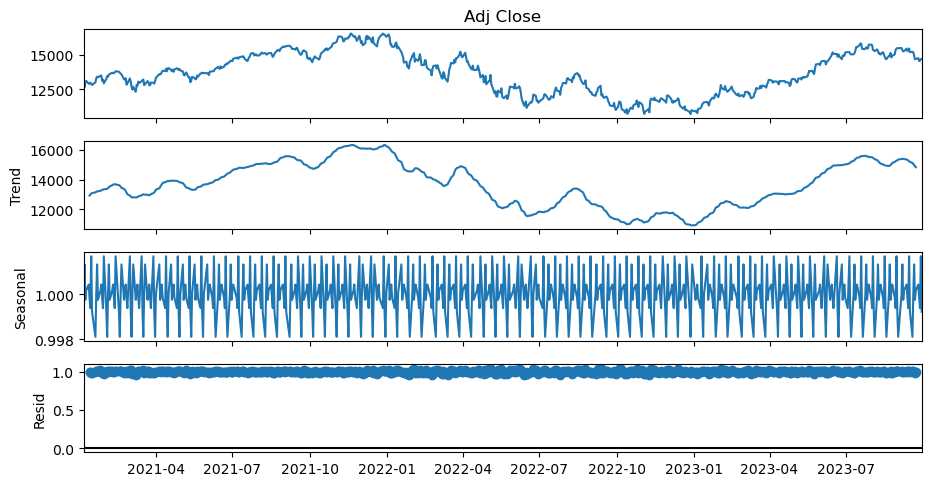

<Figure size 640x480 with 0 Axes>

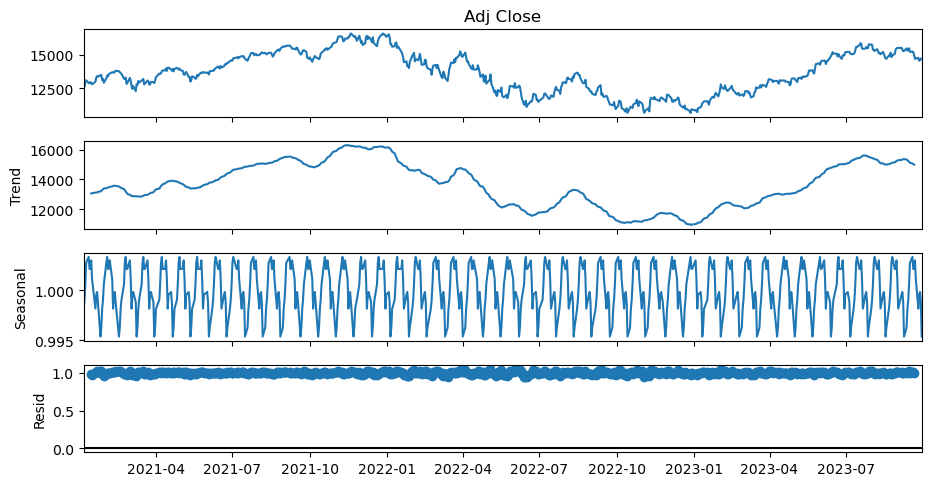

In [139]:
# Seasonality decompose
df = nasdaq_index_ac
# 5 days period decompose
decomp = seasonal_decompose(df,
                            period = 5,
                            model = 'mul')
fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(10, 5)

# 15 days period decompose
decomp = seasonal_decompose(df,
                            period = 10,
                            model = 'mul')
fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(10, 5)

# 20 days period decompose
decomp = seasonal_decompose(df,
                            period = 15,
                            model = 'mul')
fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(10, 5)
plt.show()

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predic

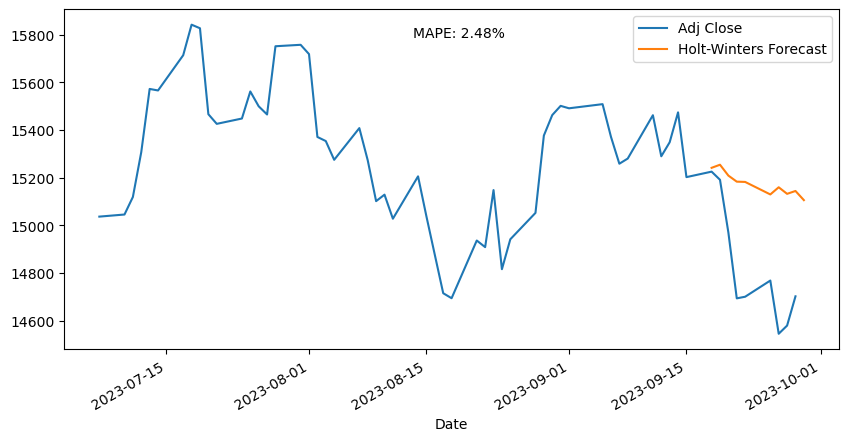

In [140]:
#Training and test set
test_days = 10
df = nasdaq_index_ac
train_set = df.iloc[:-test_days]
test_set = df.iloc[-test_days:]

# Forecasting model
model = ExponentialSmoothing(endog = train_set,
                             trend = 'mul',     # 'mul' or 'add'
                             seasonal = 'mul',  # 'mul' or 'add'
                             seasonal_periods = 15).fit()

# Predictions for work days
predictions_hw = model.forecast(steps = test_days).rename("Holt-Winters Forecast")
predictions_hw.index = test_set.index
predictions_hw.head()
# Visualization
df[-60:-1].plot(figsize = (10,5), legend = True)
predictions_hw.plot(legend = True)
# Displaying the MAPE value on the plot
m_mape = mean_absolute_percentage_error(test_set, predictions_hw) * 100
plt.text(0.45, 0.95, f'MAPE: {m_mape:.2f}%', 
         transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top')
plt.show()

## ARIMA models

### Stationarity and Dickey-Fuller Test

In [141]:
# Print the row results of the ADF test directly
print(adfuller(flights_df['passengers']))
# Define a function to interpret the ADF test results
def describe_adfuller_results(series):
    # Perform ADF test
    result = adfuller(series)
    # Format the output
    adf_results = pd.Series(result[0:4], index=[
        'Test Statistic', 'p-value', '#Lags Used',
        'Number of Observations Used'])
    # Add critical values to the series
    for key, value in result[4].items():
        adf_results[f'Critical Value ({key})'] = value
    # Display the results
    print("\nResults of Dickey-Fuller Test:")
    print(adf_results)
    # Conditional statement for interpretation
    if adf_results['p-value'] < 0.05:
        print("The time series is stationary as the p-value is below 0.05.")
    else:
        print("The time series is not stationary as the p-value is above 0.05.")
# Example usage of the function
describe_adfuller_results(flights_df['passengers'])
describe_adfuller_results(flights_df['passengers'].diff(1).dropna())
describe_adfuller_results(flights_df['passengers'].diff(2).dropna())

(0.8153688792060446, 0.9918802434376409, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.692930839019)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
The time series is not stationary as the p-value is above 0.05.

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
The time series is not stationary as the p-value is above 0.05.

Results of Dickey-Fuller Test:
Test St


Results of Dickey-Fuller Test:
Test Statistic                  -1.759928
p-value                          0.400530
#Lags Used                       0.000000
Number of Observations Used    688.000000
Critical Value (1%)             -3.439891
Critical Value (5%)             -2.865750
Critical Value (10%)            -2.569012
dtype: float64
The time series is not stationary as the p-value is above 0.05.


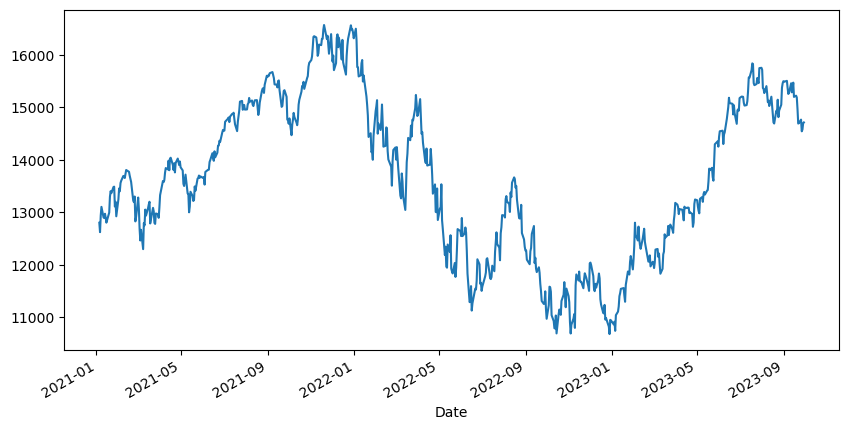


Results of Dickey-Fuller Test:
Test Statistic                 -26.975663
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    687.000000
Critical Value (1%)             -3.439904
Critical Value (5%)             -2.865756
Critical Value (10%)            -2.569015
dtype: float64
The time series is stationary as the p-value is below 0.05.


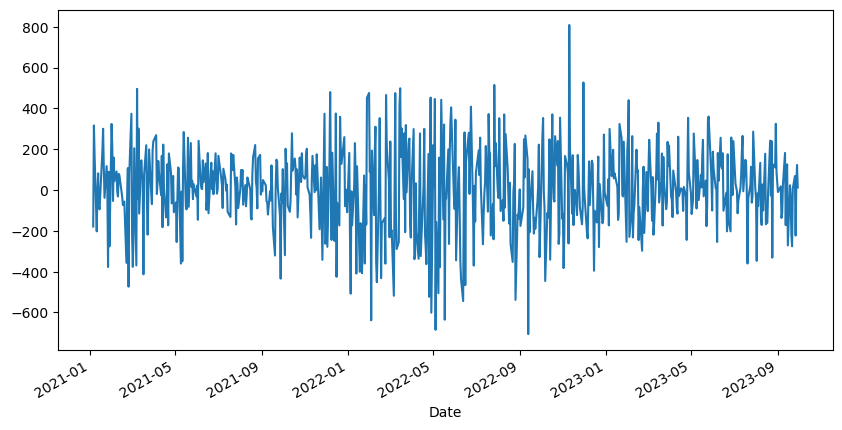


Results of Dickey-Fuller Test:
Test Statistic                 -27.089460
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    688.000000
Critical Value (1%)             -3.439891
Critical Value (5%)             -2.865750
Critical Value (10%)            -2.569012
dtype: float64
The time series is stationary as the p-value is below 0.05.


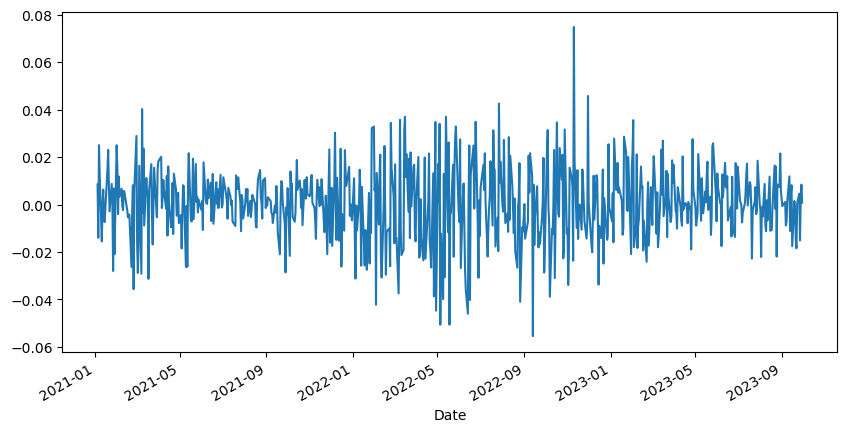

In [142]:
# Perform Augmented Dickey-Fuller test on NASDAQ Index Adjusted Close prices
# and print the results to check for stationarity
describe_adfuller_results(nasdaq_index_ac)
# Plot the NASDAQ Index Adjusted Close prices for visual inspection
nasdaq_index_ac.plot(figsize=(10, 5))
plt.show()
# Perform Augmented Dickey-Fuller test on the first-differenced NASDAQ Index
# Adjusted Close prices to check for stationarity after removing trend
describe_adfuller_results((nasdaq_index_ac - nasdaq_index_ac.shift(1)).dropna())
# Plot the first-differenced NASDAQ Index Adjusted Close prices to visualize the changes
(nasdaq_index_ac - nasdaq_index_ac.shift(1)).dropna().plot(figsize=(10, 5))
plt.show()
# Perform Augmented Dickey-Fuller test on NASDAQ Index Percent Change to check for stationarity
describe_adfuller_results(nasdaq_index_pc)
# Plot the NASDAQ Index Percent Change for visual analysis of volatility and stationarity
nasdaq_index_pc.plot(figsize=(10, 5))
plt.show()

### Autocorrelation and Partial Autocorrelation Plots

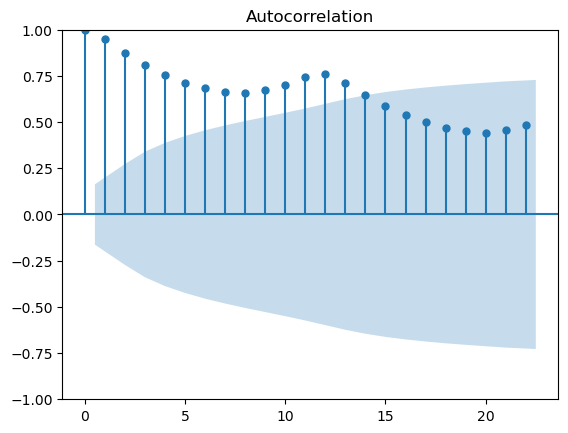

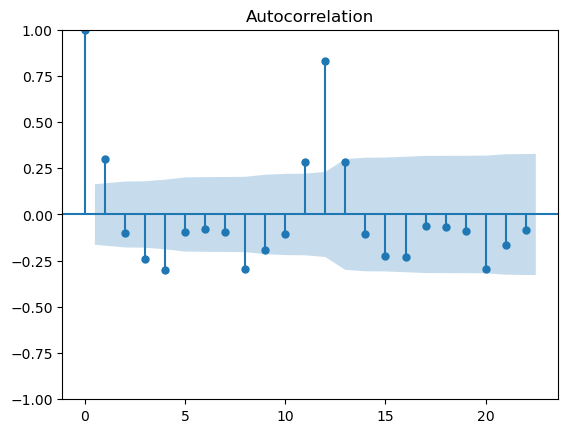

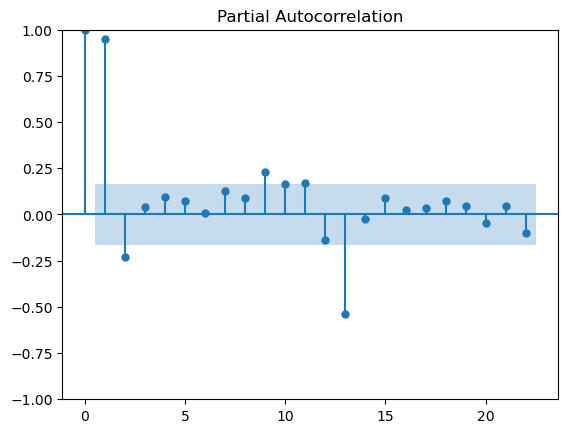

In [143]:
# Plotting Autocorrelation Function (ACF)
# ACF measures the correlation between time series observations at different lags
# Useful for identifying the MA (Moving Average) component in ARIMA modeling
fig_first = plot_acf(flights_df['passengers'])

# Plotting Autocorrelation Function (ACF) for First-Differenced Series
# This code subtracts each value in the series from the value that precedes it (first difference)
# Plotting the ACF of the first-differenced series helps identify autocorrelation after removing trend
fig_first_shift = plot_acf((flights_df['passengers'].diff(1)).dropna())

# Plotting Partial Autocorrelation Function (PACF)
# PACF measures the partial correlation between observations at different lags
# Helps in identifying the AR (Autoregressive) component for ARIMA modeling
fig_seasonal = plot_pacf(flights_df['passengers'])

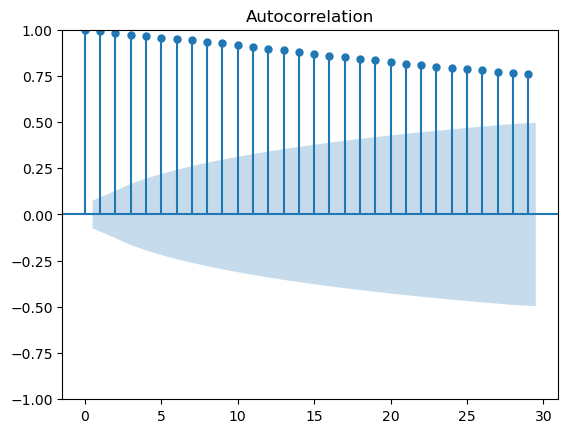

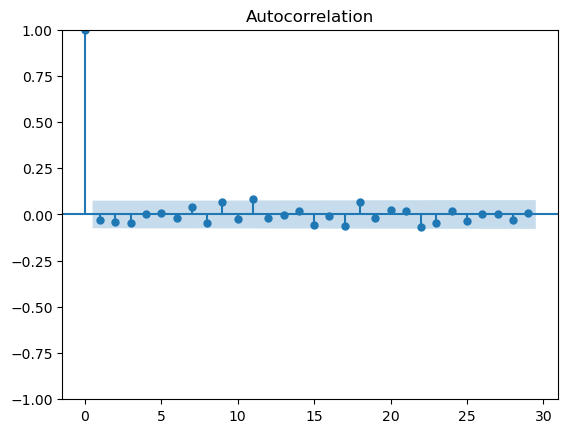

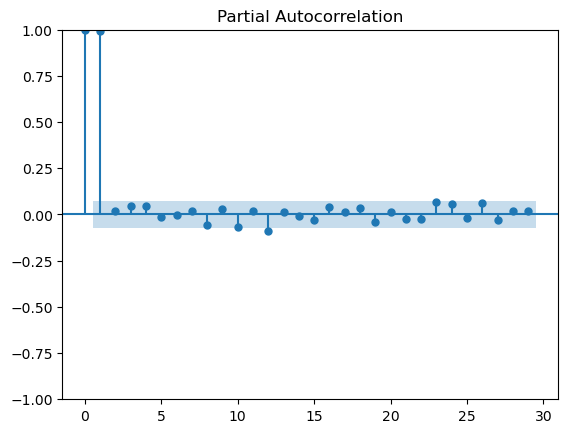

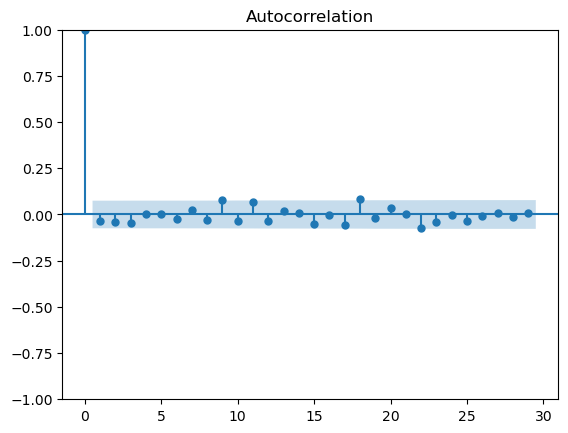

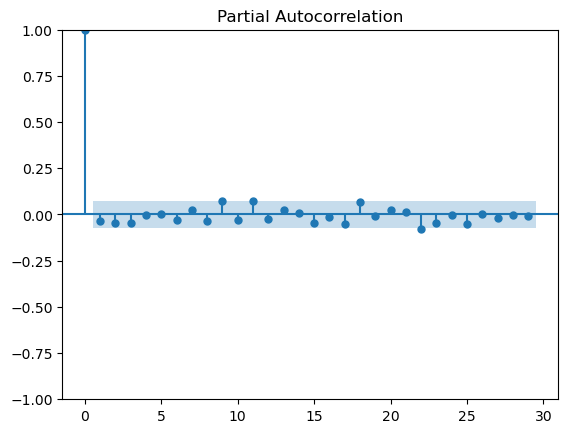

In [144]:
fig_first = plot_acf(nasdaq_index_ac)
fig_first_shift = plot_acf((nasdaq_index_ac - \
                            nasdaq_index_ac.shift(1)).dropna())
fig_seasonal1 = plot_pacf(nasdaq_index_ac)

fig_second = plot_acf(nasdaq_index_pc)
fig_seasonal2 = plot_pacf(nasdaq_index_pc)

### ARIMA custom

                               SARIMAX Results                                
Dep. Variable:             passengers   No. Observations:                  132
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -607.782
Date:                Tue, 11 Jun 2024   AIC                           1225.563
Time:                        13:49:01   BIC                           1239.939
Sample:                    01-31-1949   HQIC                          1231.405
                         - 12-31-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6660      0.024     68.561      0.000       1.618       1.714
ar.L2         -0.9294      0.022    -41.536      0.000      -0.973      -0.886
ma.L1         -1.8324      0.032    -56.857      0.0

Text(0.45, 0.95, 'MAPE: 8.22%')

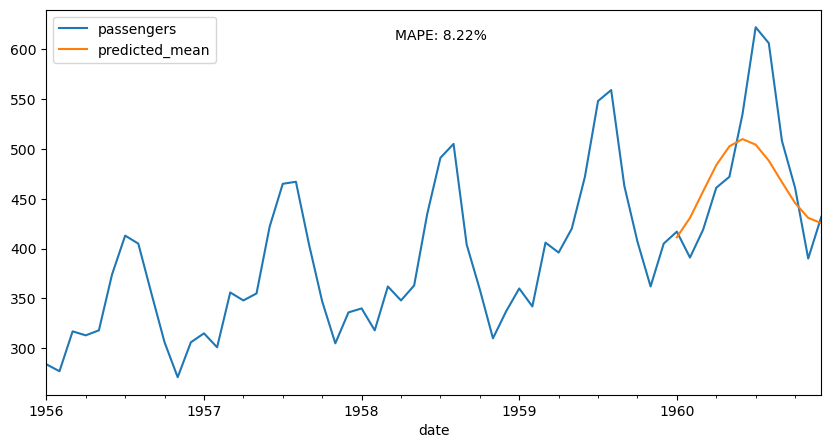

In [145]:
from statsmodels.tsa.arima.model import ARIMA
# Settings
test_periods = 12  # Assuming you want to forecast the last 12 periods
df = flights_df['passengers']
# Splitting the dataset into training and test sets
train_set = df.iloc[:-test_periods]
test_set = df.iloc[-test_periods:]
# Define the ARIMA model with seasonal_order
model = ARIMA(train_set,
              order=(2, 1, 2))
results = model.fit()
print(results.summary())
# Forecast the next test periods
forecast = results.get_forecast(steps=test_periods)
predictions = pd.Series(forecast.predicted_mean)
predictions.index = test_set.index
# Visualization
df[-60:].plot(figsize = (10,5), legend = True)
predictions.plot(legend = True)
# Displaying the MAPE value on the plot
m_mape = mean_absolute_percentage_error(test_set, predictions) * 100
plt.text(0.45, 0.95, f'MAPE: {m_mape:.2f}%', 
         transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top')

### SARIMA Simulation (additional material)

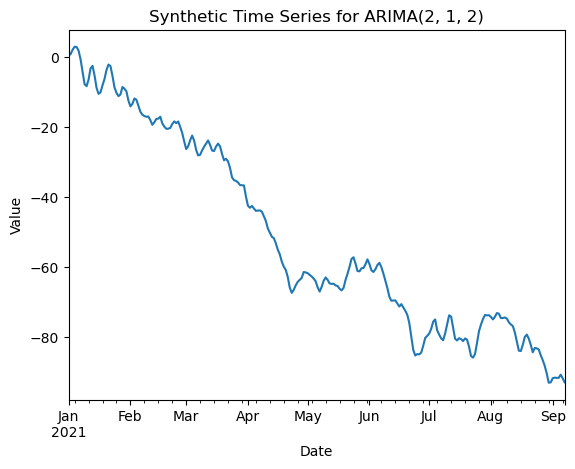

In [146]:
from statsmodels.tsa.arima_process import ArmaProcess
# Define AR and MA coefficients
# AR coefficients should be for ARIMA(p, d, q) model of the form [1, -phi1, -phi2, ..., -phip]
# MA coefficients should be for ARIMA(p, d, q) model of the form [1, theta1, theta2, ..., thetaq]
# Note: The signs of the phi values are negative because of the way the ARMA process is defined in statsmodels
ar_coefs = [1, -0.5, 0.25]  # Corresponds to an AR(2) with phi1=0.5, phi2=-0.25
ma_coefs = [1, 0.5, 0.25]   # Corresponds to an MA(2) with theta1=0.5, theta2=0.25

# Generate the sample ARMA process
arma_process = ArmaProcess(ar=ar_coefs, ma=ma_coefs)
sample_size = 250  # Define the size of the time series
synthetic_data = arma_process.generate_sample(nsample=sample_size)

# Since ARIMA(2, 1, 2) includes one differencing, we need to integrate the series
# Integrating the ARMA process to make it ARIMA
synthetic_data = np.cumsum(synthetic_data)  

# Create a pandas series with a time index
date_range = pd.date_range(start='2021-01-01', 
                           periods=sample_size, freq='D')
time_series = pd.Series(synthetic_data, index=date_range)

# Plot the synthetic time series
time_series.plot(title='Synthetic Time Series for ARIMA(2, 1, 2)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


In [147]:
# Settings
test_periods = 12  # Assuming you want to forecast the last 12 periods
seasonal_periods = 12  # Assuming yearly seasonality for monthly data

# Splitting the dataset into training and test sets
train_set = time_series.iloc[:-test_periods]
test_set = time_series.iloc[-test_periods:]

# Define the SARIMAX model with seasonal_order
model = sm.tsa.statespace.SARIMAX(
    train_set,
    order=(2, 1, 2)
)
results = model.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43841D+00    |proj g|=  3.91941D-03

At iterate    5    f=  1.43837D+00    |proj g|=  3.17618D-03

At iterate   10    f=  1.43835D+00    |proj g|=  5.52525D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   5.525D-06   1.438D+00
  F =   1.4383537565414422     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                               SARIMAX Results                        

 This problem is unconstrained.


5.317333857671393


<Axes: >

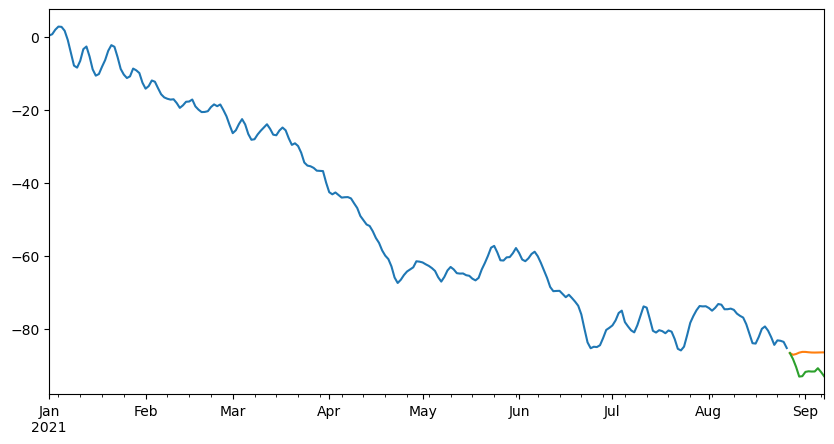

In [148]:
# Forecast the next 12 periods
forecast = results.get_forecast(steps=12)
forecast_index = pd.date_range(start=train_set.index[-1], 
                               periods=test_periods+1, 
                               freq='D')[1:]
forecast_series = pd.Series(forecast.predicted_mean, 
                            index=test_set.index)
print(mean_absolute_percentage_error(forecast_series, 
                                     test_set) * 100)
train_set.plot(figsize=[10,5])
forecast_series.plot()
test_set.plot()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.84891D+00    |proj g|=  1.32009D-01

At iterate    5    f=  1.79121D+00    |proj g|=  1.70354D-02

At iterate   10    f=  1.78914D+00    |proj g|=  1.47409D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   5.257D-07   1.789D+00
  F =   1.7891353708834863     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Results                 

 This problem is unconstrained.


<Axes: >

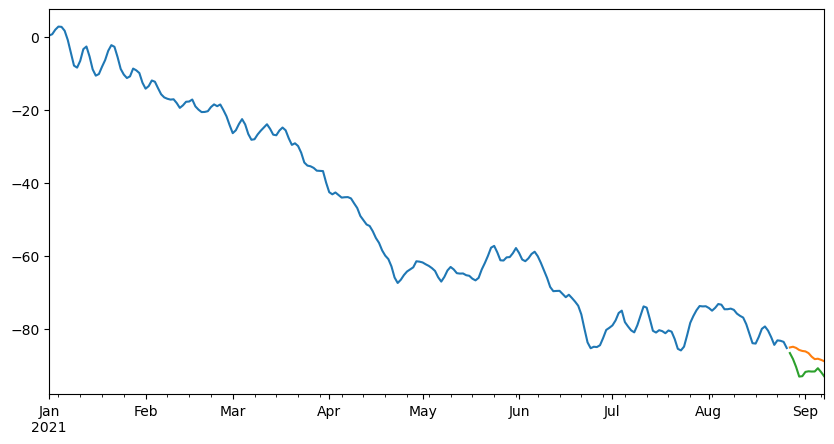

In [149]:
# Settings
test_periods = 12  # Assuming you want to forecast the last 12 periods
seasonal_periods = 12  # Assuming yearly seasonality for monthly data

# Splitting the dataset into training and test sets
train_set = time_series.iloc[:-test_periods]
test_set = time_series.iloc[-test_periods:]

# Define the SARIMAX model with seasonal_order
model = sm.tsa.statespace.SARIMAX(
    train_set,
    order=(0, 1, 0),  # Non-seasonal order
    seasonal_order=(1, 1, 1, seasonal_periods)  # Seasonal order
)
results = model.fit()
print(results.summary())

# Forecast the next 12 periods
forecast = results.get_forecast(steps=12)
forecast_index = pd.date_range(start=train_set.index[-1], 
                               periods=test_periods+1,
                               freq='D')[1:]
forecast_series = pd.Series(forecast.predicted_mean, 
                            index=test_set.index)
print(mean_absolute_percentage_error(forecast_series, 
                                     test_set) * 100)

train_set.plot(figsize=[10,5])
forecast_series.plot()
test_set.plot()

### Auto SARIMAX tunning

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  132
Model:             SARIMAX(0, 1, 3)x(0, 1, [], 12)   Log Likelihood                -445.348
Date:                             Tue, 11 Jun 2024   AIC                            898.695
Time:                                     13:49:10   BIC                            909.812
Sample:                                 01-31-1949   HQIC                           903.210
                                      - 12-31-1959                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2533      0.086     -2.940      0.003      -0.422      -0.084
ma.L2          0.1373      

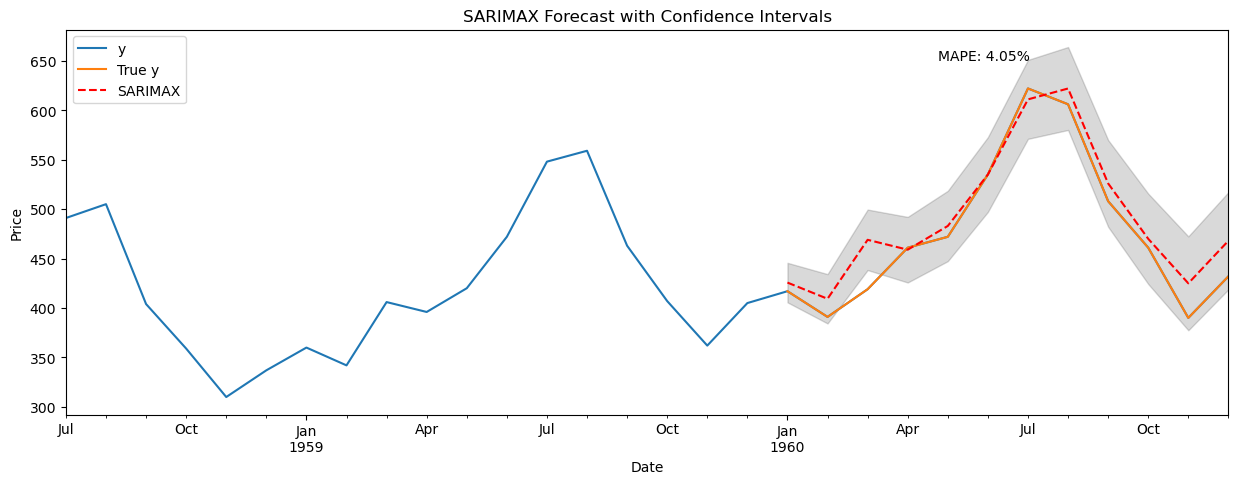

In [150]:
# Auto-detect the parameters for SARIMA model
# Import auto_arima
from pmdarima import auto_arima
data = flights_df['passengers']
dataframe = pd.DataFrame({'y': data})
# Split into train and test sets
test_size = 12
train_set = dataframe.iloc[:-test_size]
test_set = dataframe.iloc[-test_size:]
# Forecasting model
model = pm.auto_arima(y = train_set['y'],
                   d = 1,
                   m = 12,
                   n_jobs = -1,
                   seasonal = True,
                   stepwise = False)
print(model.summary())
# Generate predictions and confidence intervals
forecast, conf_int = model.predict(n_periods=test_size,
                                   return_conf_int=True)
# Convert forecast and confidence intervals to pandas Series for easier plotting
predictions = pd.Series(forecast).rename("SARIMAX")
predictions.index=test_set.index
m_mape = mean_absolute_percentage_error(test_set['y'], predictions) * 100
lower_conf = pd.Series(conf_int[:, 0],
                       index=test_set.index).rename("Lower CI")
upper_conf = pd.Series(conf_int[:, 1],
                       index=test_set.index).rename("Upper CI")
# Plotting the observed data, forecast, and confidence intervals
plt.figure(figsize=(15, 5))
dataframe[-30:]['y'].plot(legend=True,
                          title='SARIMAX Forecast with Confidence Intervals')
test_set['y'].rename('True y').plot(legend=True)
# Plotting the confidence intervals
predictions.plot(legend=True, color='red', linestyle='--')
# Plotting the confidence intervals
plt.fill_between(lower_conf.index, lower_conf,
                 upper_conf, color='k', alpha=0.15)
# Displaying the MAPE value on the plot
plt.text(0.75, 0.95, f'MAPE: {m_mape:.2f}%',
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(2, 1, 2)x(1, 0, 2, 12)   Log Likelihood                -500.684
Date:                            Tue, 11 Jun 2024   AIC                           1021.367
Time:                                    13:49:21   BIC                           1050.119
Sample:                                01-31-1949   HQIC                          1033.050
                                     - 12-31-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8433      2.990      0.282      0.778      -5.017       6.703
month         -1.3257      2.225   

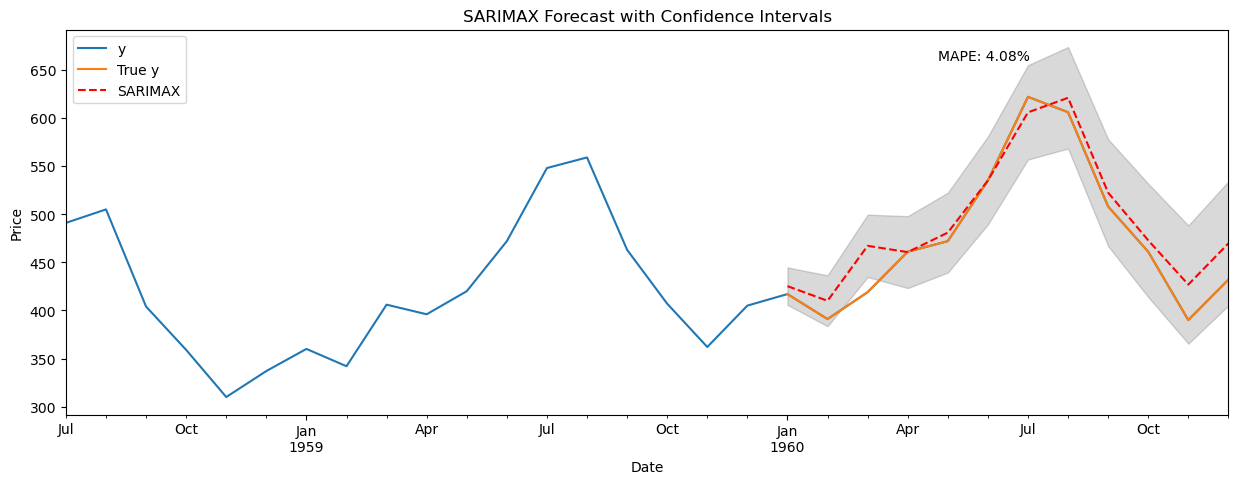

In [151]:
# Auto-detect the parameters for SARIMAX model
# Import auto_arima
from pmdarima import auto_arima
data = flights_df['passengers']
dataframe = pd.DataFrame({
    'y': data,
    'year': data.index.year,
    'month': data.index.month})
# Split into train and test sets
test_size = 12
train_set = dataframe.iloc[:-test_size]
test_set = dataframe.iloc[-test_size:]
# Forecasting model
model = pm.auto_arima(y = train_set['y'],
                   X = train_set[['month']],
                   d = 1,
                   m = 12,
                   n_jobs = -1,
                   seasonal = True,
                   stepwise = True)
print(model.summary())
# Generate predictions and confidence intervals
forecast, conf_int = model.predict(n_periods=test_size,
                                   X=test_set[['month']],
                                   return_conf_int=True)
# Convert forecast and confidence intervals to pandas Series for easier plotting
predictions = pd.Series(forecast).rename("SARIMAX")
predictions.index=test_set.index
m_mape = mean_absolute_percentage_error(test_set['y'], 
                                        predictions) * 100
lower_conf = pd.Series(conf_int[:, 0],
                       index=test_set.index).rename("Lower CI")
upper_conf = pd.Series(conf_int[:, 1],
                       index=test_set.index).rename("Upper CI")
# Plotting the observed data, forecast, and confidence intervals
plt.figure(figsize=(15, 5))
dataframe[-30:]['y'].plot(legend=True,
                          title='SARIMAX Forecast with Confidence Intervals')
test_set['y'].rename('True y').plot(legend=True)
# Plotting the confidence intervals
predictions.plot(legend=True, color='red', linestyle='--')
# Plotting the confidence intervals
plt.fill_between(lower_conf.index, lower_conf, 
                 upper_conf, color='k', alpha=0.15)
# Displaying the MAPE value on the plot
plt.text(0.75, 0.95, f'MAPE: {m_mape:.2f}%',
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  182
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 10)   Log Likelihood                -241.427
Date:                            Tue, 11 Jun 2024   AIC                            492.854
Time:                                    13:49:25   BIC                            508.846
Sample:                                         0   HQIC                           499.338
                                            - 182                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0563      0.080      0.699      0.484      -0.101       0.214
month         -0.9931      0.241   

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Figure size 640x480 with 0 Axes>

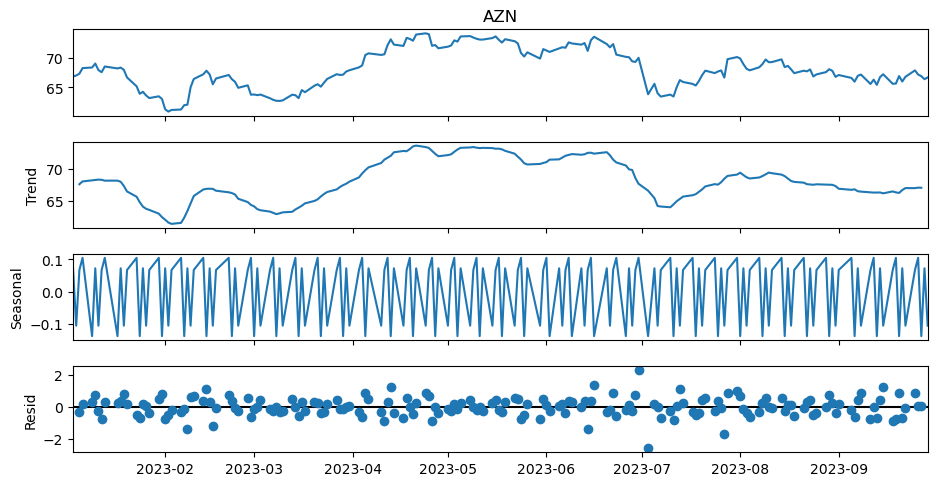

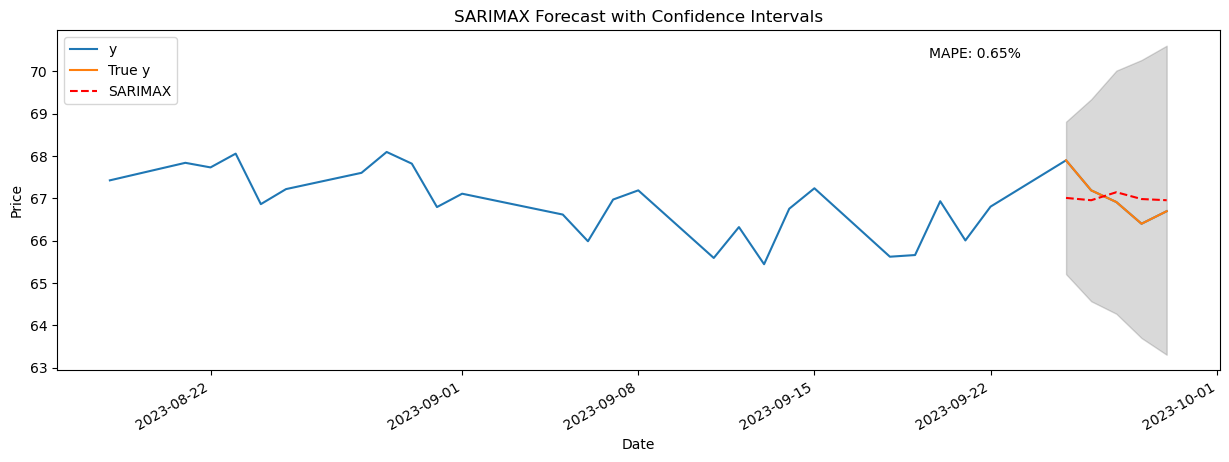

In [152]:
# The Real-World Example for AstraZeneca PLC Stock Price
# Auto-detect the parameters for SARIMAX model
from pmdarima import auto_arima
# Seasonality decompose
data = nasdaq_assets_ac['AZN']['2023']
decomp = seasonal_decompose(data,
                            period = 5,
                            model = 'add')
fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(10, 5)
# SARIMAX model tuning
data = nasdaq_assets_ac['AZN']['2023']
dataframe = pd.DataFrame({
    'y': data,
    'day': data.index.day,
    'month': data.index.month,
    'day_year': data.index.dayofyear})
dataframe.dropna(inplace=True)
# Split into train and test sets
test_size = 5
train_set = dataframe.iloc[:-test_size]
test_set = dataframe.iloc[-test_size:]
#forecasting model
model = pm.auto_arima(y = train_set['y'],
                   X = train_set[['month']],
                   d = 1,
                   m = 10,
                   n_jobs = -1,
                   seasonal = True,
                   stepwise = False)
print(model.summary())
# Generate predictions and confidence intervals
forecast, conf_int = model.predict(n_periods=test_size,
                                   X=test_set[['month']],
                                   return_conf_int=True)
# Convert forecast and confidence intervals to pandas Series for easier plotting
predictions = pd.Series(forecast).rename("SARIMAX")
predictions.index=test_set.index
m_mape = mean_absolute_percentage_error(test_set['y'], predictions) * 100
lower_conf = pd.Series(conf_int[:, 0],
                       index=test_set.index).rename("Lower CI")
upper_conf = pd.Series(conf_int[:, 1],
                       index=test_set.index).rename("Upper CI")
# Plotting the observed data, forecast, and confidence intervals
plt.figure(figsize=(15, 5))
dataframe[-30:]['y'].plot(legend=True,
                          title='SARIMAX Forecast with Confidence Intervals')
test_set['y'].rename('True y').plot(legend=True)
# Plotting the confidence intervals
predictions.plot(legend=True, color='red', linestyle='--')
# Plotting the confidence intervals
plt.fill_between(lower_conf.index, lower_conf, 
                 upper_conf, color='k', alpha=0.15)
# Displaying the MAPE value on the plot
plt.text(0.75, 0.95, f'MAPE: {m_mape:.2f}%',
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

### Cross-Correlation Function for exogenous variables (additional material)

56


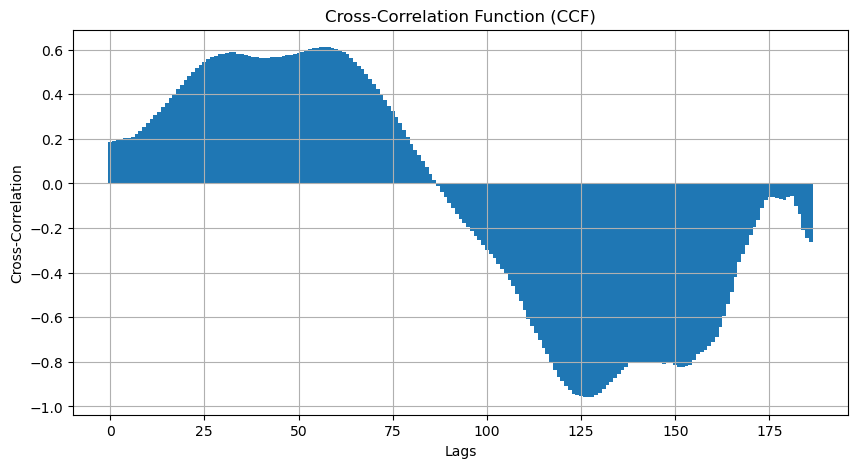

In [153]:
# Plotting Cross-Correlation Function
series1 = nasdaq_index_ac['2023']
series2 = nasdaq_assets_ac['AZN']['2023']
cross_corr = sm.tsa.stattools.ccf(series1, series2)
print(cross_corr.argmax())
# Define the lags
lags = np.arange(len(cross_corr))
# Create the bar plot
plt.figure(figsize=(10, 5))
plt.bar(lags, cross_corr, width=1)
# Add labels and title
plt.xlabel('Lags')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation Function (CCF)')
# Show grid
plt.grid(True)
plt.show()

In [154]:
# The Real-World Example for AstraZeneca PLC Stock Price
# Auto-detect the parameters for SARIMAX model 2
data = nasdaq_assets_ac['AZN']['2023']
dataframe = pd.DataFrame({
    'y': data,
    'index': nasdaq_index_ac['2023'].shift(56)})
dataframe.dropna(inplace=True)
# Split into train and test sets
test_size = 5
train_set = dataframe.iloc[:-test_size]
test_set = dataframe.iloc[-test_size:]
#forecasting model
model = pm.auto_arima(y = train_set['y'], 
                      X = train_set[['index']],
                      d = 1, m = 10, n_jobs = -1,
                      seasonal = True, stepwise = False)
print(model.summary())
# Generate predictions and confidence intervals
forecast, conf_int = model.predict(n_periods=test_size,
                                   X=test_set[['index']],
                                   return_conf_int=True)
# Convert forecast and confidence intervals to pandas Series for easier plotting
predictions = pd.Series(forecast).rename("SARIMAX")
predictions.index=test_set.index
m_mape = mean_absolute_percentage_error(test_set['y'], 
                                        predictions) * 100
print('MAPE: ', m_mape)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  126
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -173.210
Date:                Tue, 11 Jun 2024   AIC                            354.420
Time:                        13:49:28   BIC                            365.733
Sample:                             0   HQIC                           359.016
                                - 126                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0411      0.101     -0.408      0.683      -0.238       0.156
index          0.0008      0.001      1.141      0.254      -0.001       0.002
ar.L1         -0.2067      0.111     -1.864      0.0

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Chapter 7
## &copy; Dr. Dmytro Zherlitsyn, 2023 <br>
## &copy; BPB Publications, 2023